# SMARTS selection and depiction
## Depict molecular components selected by a particular SMARTS

This notebook focuses on selecting molecules containing fragments matching a particular SMARTS query, and then depicting the components (i.e. bonds, angles, torsions) matching that particular query. 

In [1]:
import openeye.oechem as oechem
import openeye.oedepict as oedepict
from IPython.display import display
import os
from __future__ import print_function

In [2]:
def depictMatch(mol, match, width=500, height=200):
    """Take in an OpenEye molecule and a substructure match and display the results
    with (optionally) specified resolution."""
    
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(True)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    hstyle = oedepict.OEHighlightStyle_Color
    hcolor = oechem.OEColor(oechem.OELightBlue)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))

In [3]:
import parmed
def createOpenMMSystem(mol):
    """
    Generate OpenMM System and positions from an OEMol.
    
    Parameters
    ----------
    mol : OEMol
        The molecule
        
    Returns
    -------
    system : simtk.openmm.System
       The OpenMM System
    positions : simtk.unit.Quantity wrapped 
       Positions of the molecule
    """
    # write mol2 file
    ofsmol2 = oechem.oemolostream('molecule.mol2')
    ofsmol2.SetFlavor( oechem.OEFormat_MOL2, oechem.OEOFlavor_MOL2_Forcefield );
    oechem.OEWriteConstMolecule(ofsmol2, mol)
    ofsmol2.close()
    # write tleap input file
    leap_input = """
    lig = loadMol2 molecule.mol2
    saveAmberParm lig prmtop inpcrd   
    quit
    """
    outfile = open('leap.in', 'w')
    outfile.write(leap_input)
    outfile.close()
    # run tleap
    leaprc = 'leaprc.Frosst_AlkEthOH'
    os.system( 'tleap -f %s -f leap.in > leap.out' % leaprc )
    # check if param file was not saved (implies parameterization problems)
    paramsNotSaved = 'Parameter file was not saved'
    leaplog = open( 'leap.out', 'r' ).read()
    if paramsNotSaved in leaplog:
        raise Exception('Parameter file was not saved.')
    # Read prmtop and inpcrd
    amberparm = parmed.amber.AmberParm( 'prmtop', 'inpcrd' )
    system = amberparm.createSystem()
    return (system, amberparm.positions)

import copy
from simtk import openmm, unit

def getValenceEnergyComponent(system, positions, atoms):
    """
    Get the OpenMM valence energy corresponding to a specified set of atoms (bond, angle, torsion).
    
    Parameters
    ----------
    system : simtk.openmm.System
       The OpenMM System object for the molecule
    positions : simtk.unit.Quantity of dimension (natoms,3) with units compatible with angstroms
       The positions of the molecule
    atoms : list or set of int
       The set of atoms in the bond, angle, or torsion.

    Returns
    -------
    potential : simtk.unit.Quantity with units compatible with kilocalories_per_mole
       The energy of the valence component.
    """
    atoms = set(atoms)
    natoms = len(atoms) # number of atoms
    # Create a copy of the original System object so we can manipulate it
    system = copy.deepcopy(system)
    # Determine Force types to keep
    if natoms == 2:
        forcename = 'HarmonicBondForce'
    elif natoms == 3:
        forcename = 'HarmonicAngleForce'
    elif natoms == 4:
        forcename = 'PeriodicTorsionForce'
    else:
        raise Exception('len(atoms) = %d, but must be in [2,3,4] for bond, angle, or torsion' % len(atoms))
    # Discard Force objects we don't need
    for force_index in reversed(range(system.getNumForces())):
        if system.getForce(force_index).__class__.__name__ != forcename:
            system.removeForce(force_index)

    # Report on constraints
    if forcename == 'HarmonicBondForce':
        for constraint_index in range(system.getNumConstraints()):
            [i, j, r0] = system.getConstraintParameters(constraint_index)
            if set([i,j]) == atoms:
                print('Bond is constrained')        
            
    # Zero out force components that don't involve the atoms
    for force_index in range(system.getNumForces()):
        force = system.getForce(force_index)
        if forcename == 'HarmonicBondForce':
            for param_index in range(force.getNumBonds()):
                [i, j, r0, K] = force.getBondParameters(param_index)
                if set([i,j]) != atoms:
                    K *= 0
                else:
                    print('Match found: bond parameter %d : r0 = %s, K = %s' % (param_index, str(r0), str(K)))
                force.setBondParameters(param_index, i, j, r0, K)
        elif forcename == 'HarmonicAngleForce':
            for param_index in range(force.getNumAngles()):
                [i, j, k, theta0, K] = force.getAngleParameters(param_index)
                if set([i,j,k]) != atoms:
                    K *= 0
                else:
                    print('Match found: angle parameter %d : theta0 = %s, K = %s' % (param_index, str(theta0), str(K)))
                force.setAngleParameters(param_index, i, j, k, theta0, K)
        elif forcename == 'PeriodicTorsionForce':
            for param_index in range(force.getNumTorsions()):
                [i, j, k, l, periodicity, phase, K] = force.getTorsionParameters(param_index)
                if set([i,j,k,l]) != atoms:
                    K *= 0
                else:
                    print('Match found: torsion parameter %d : periodicity = %s, phase = %s, K = %s' % (param_index, str(periodicity), str(phase), str(K)))
                force.setTorsionParameters(param_index, i, j, k, l, periodicity, phase, K)
    # Compute energy
    platform = openmm.Platform.getPlatformByName('Reference')
    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator, platform)
    context.setPositions(positions)
    potential = context.getState(getEnergy=True).getPotentialEnergy()
    del context, integrator, system
    # Return energy
    return potential
    

In [4]:
#SMARTS query defining your search (and potentially forcefield term of interest)
#Note currently this must specify an angle term for the OpenMM energy to be
Smarts = '[#6X4]-[#6X4]-[#8X2]' # angle example
Smarts = '[a,A]-[#6X4]-[#8X2]-[#1]' # torsion example
Smarts = '[#6X4]-[#6X4]' # bond example

#Set up substructure query
qmol = oechem.OEQMol()
if not oechem.OEParseSmarts( qmol, Smarts ):
    print( 'OEParseSmarts failed')
ss = oechem.OESubSearch( qmol)

In [5]:
#File to search for this substructure
fileprefix= 'AlkEthOH_dvrs1'
ifs = oechem.oemolistream(fileprefix+'.oeb')

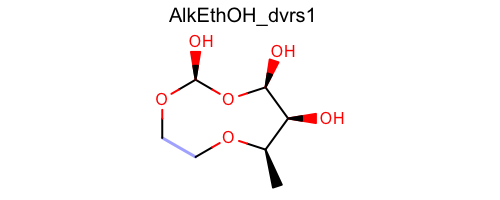

0 1 


UnboundLocalError: local variable 'force' referenced before assignment

In [6]:
#Do substructure search and depiction
mol = oechem.OEMol()
#Loop over molecules in file
for mol in ifs.GetOEMols():
    # Get OpenMM System and positions.
    [system, positions] = createOpenMMSystem(mol)
    
    
    goodMol = True
    oechem.OEPrepareSearch(mol, ss)
    unique = True
    #Loop over matches within this molecule in file and depict
    for match in ss.Match(mol, unique):
        display( depictMatch(mol, match))
        atoms = list()
        for ma in match.GetAtoms():
            print(ma.target.GetIdx(), end=" ")          
            #print(ma.pattern.GetIdx(), end=" ")
            atoms.append( ma.target.GetIdx() )
        print('')
        #Get OpenMM angle energy and print IF it's an angle term
        potential = getValenceEnergyComponent(system, positions, atoms)
        print('%16.10f kcal/mol' % (potential / unit.kilocalories_per_mole))

In [ ]:
ifs.close()